# Interpreting the House Prices

This is part three of the three part interpretation assignment:
1. [Interpretation and Significance](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/interp_significance_assignment.md)
2. [Interpreting the Weather](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/interpreting_temp.ipynb)
3. [Interpreting the House Prices](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/interpreting_house_prices.ipynb)

### House prices model

In this exercise, you'll interpret your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Run your house prices model again and interpret the results. Which features are statistically significant, and which are not?
* Now, exclude the insignificant features from your model. Did anything change?
* Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?
* Do the results sound reasonable to you? If not, try to explain the potential reasons.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Cleaning

In [3]:
df.drop(columns='id', inplace=True)

In [4]:
cat_list = ['mssubclass','mszoning','street','alley','lotshape','landcontour','utilities','lotconfig','landslope','neighborhood','condition1','condition2',
            'bldgtype','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd','masvnrtype','exterqual','extercond','foundation','bsmtqual','bsmtcond',
            'bsmtexposure','bsmtfintype1','bsmtfintype2','heating','heatingqc','centralair','electrical','kitchenqual','functional','fireplacequ','garagetype',
            'garagefinish','garagequal','garagecond','paveddrive','poolqc','fence','miscfeature','saletype','salecondition', 'overallqual', 'overallcond', 
            'yearbuilt', 'yearremodadd', 'mosold', 'yrsold']
for var in cat_list:
    df[var] = df[var].astype('category')

In [5]:
def add_cat_fillna(variable, new_cat='None'):
    df[variable] = df[variable].cat.add_categories(new_cat).fillna(new_cat).copy()

In [6]:
nulls_list = ['alley','bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2','fireplacequ','garagetype','garagefinish','garagequal','garagecond',
             'poolqc','fence','miscfeature']
for var in nulls_list:
    add_cat_fillna(var)

In [7]:
df.masvnrtype = df.masvnrtype.fillna('None').copy()
df.masvnrarea = df.masvnrarea.fillna(0).copy()
df.lotfrontage = df.lotfrontage.fillna(df.lotfrontage.median()).copy()
df.electrical = df.electrical.fillna(df.electrical.mode()[0]).copy()
df.drop(columns='garageyrblt', inplace=True)

In [8]:
def outliers_std(data, columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [9]:
df.drop(outliers_std(df, df.describe().columns), inplace=True)

Cleaning done!

# Feature Engineering

In [10]:
data = pd.DataFrame()
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['grlivarea'] = df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['totalbath'] = df.fullbath + df.halfbath * .5
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data['target'] = df.saleprice

# Modeling

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

target = scaled_data.iloc[:, -1]
X_data = scaled_data.iloc[:, :-1]

X_train, X_test, Y_train, Y_test = train_test_split(X_data, target, test_size=.3, random_state=14)

lm = LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)

### Evaluation

Mean squared error: 0.14799213143302944
Mean absolute error: 0.3027049260070816
R^2: 0.8393921114674023


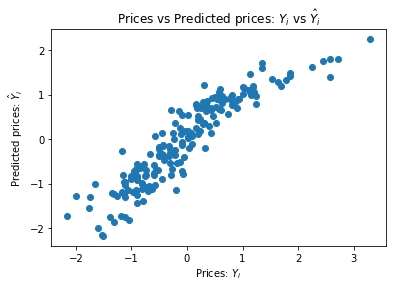

In [12]:
from sklearn import metrics
def evaluate(Y_test, Y_pred):
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    msa = metrics.mean_absolute_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)
    
    print('Mean squared error:', mse)
    print('Mean absolute error:', msa)
    print('R^2:', r2)
    
    plt.scatter(Y_test, Y_pred)
    plt.xlabel('Prices: $Y_i$')
    plt.ylabel('Predicted prices: $\hat{Y}_i$')
    plt.title('Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$')
evaluate(Y_test, Y_pred)

In [13]:
import statsmodels.api as sm
sm_X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, sm_X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     239.3
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          1.04e-132
Time:                        08:22:54   Log-Likelihood:                -300.03
No. Observations:                 431   AIC:                             614.1
Df Residuals:                     424   BIC:                             642.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0036      0.024      0.151   

Alright, so based on the above model, it appears that the constant and the totalbath coefficients are not significant. Let's see what happens when totalbath is removed from the model.

In [22]:
def run_it():
    target = data.iloc[:, -1]
    X_data = data.iloc[:, :-1]

    X_train, X_test, Y_train, Y_test = train_test_split(X_data, target, test_size=.3, random_state=14)

    lm = LinearRegression()
    lm.fit(X_train, Y_train)
    Y_pred = lm.predict(X_test)
    
    evaluate(Y_test, Y_pred)
    plt.show()
    
    sm_X_train = sm.add_constant(X_train)
    results = sm.OLS(Y_train, sm_X_train).fit()
    print(results.summary())

In [17]:
data.drop(columns='totalbath', inplace=True)

Mean squared error: 345974548.0385919
Mean absolute error: 14779.93190843997
R^2: 0.8431350054220433


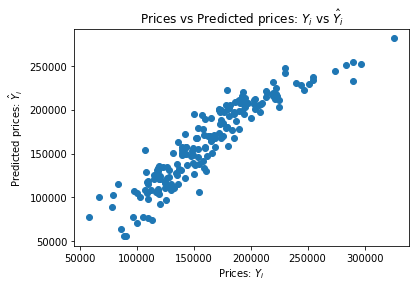

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     285.1
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          2.67e-133
Time:                        08:43:44   Log-Likelihood:                -4955.5
No. Observations:                 431   AIC:                             9923.
Df Residuals:                     425   BIC:                             9947.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.265e+04   8775.633      4.859   

In [23]:
run_it()

Based on the above (on non-scaled data), all the information is significant, the most surprising factor appears to be that as bedroom above ground goes up, the house price actually goes down. This is odd, as you would likely expect the opposite. However, I believe a number of these variables are highly correlated with one another, which is likely messing with the modeling.